### 1. 클래스 활성화 맵(Class Activation Map, CAM) 
- 클래스 활성화 맵은 주로 합성곱 신경망을 활용
- 합성곱 신경망은 합성곱 연산을 수행하고 특징 맵을 생성하는데 CAM은 특징맵을 활용해 입력 이미지의 어떠한 부분이 특정 클래스와 관련있는지 시각화(Heat Map)
#### 1). 클래스 활성화 맵(CAM) 생성방식
- CAM은 합성곱 신경망의 특징 맵의 채널과 분류기의 매개변수값을 활용해 생성
- 특징맵은 각 채널과 분류기의 가중치를 곱해 채널마다 가중치의 합을 계산
- 이 값을 정규화해 어느 영역에서 가장 강하게 활성화되는지를 수치화하고, 이를 시각화하여 분류하여 분류 결과에 영향을 미치는 영역을 파악함
- 합성곱 신경망의 마지막 합성곱 계층은 특징 맵을 계산하는 계층임.
- 이 계층에서 전역평균풀링(Global Average Pooling, GAP)을 적용해 각 픽셀에 대한 정보를 1차원으로 펴고 이를 출력으로 사용
- GAP를 통과하면서 특징 맵의 채널별로 특징값들을 통합하고, 이 값을 분류기에 전달함
- 이때 사용하는 분류기의 매개변수가 출력 클래스에 대한 특징값 가중치가 됨
- 그러므로 가중치가 높을수록 분류에 많은 영얗을 주게 되고, 반대로 가중치가 낮을수록 분류에 영향이 작다.

- **GAP를 활용하면 합성곱 신경망이 각 클래스에 어떤 특징을 활용해 분류를 수행하는지 확일할 수 있고, 시각화가 가능함**

In [3]:
# 클래스 활성화 맵(CAM) 적용

# ResNet-18모델 특징 추출
from torch import nn
from torchvision import models


model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1").eval()
features = nn.Sequential(*list(model.children())[:-2])
# model.children() ; 모델 내부 레이어를 순서대로 반환- 마지막 2개 제외(avgpool, fc 제외)
# 분류기(Classifier)를 제거하고 특징 추출기만 쓰려고
# conv1, bn1, relu, maxpool, layer1, layer2, layer3, layer4
features

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

### 2. 특징 맵과 가중치 추출

In [5]:
# 특징 맵과 가중치 추출
from PIL import Image
from torchvision import transforms

# 전처리
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)
# 이미지 로드
image = Image.open("../datasets/images/airplane.jpg")

# (3, 224, 224) -> (1, 3, 224, 224) 배치차원 추가하여 모델 입력형태를 맞춤
target = transform(image).unsqueeze(0)

output = model(target) # 추론 
# 가장 높은 점수 클래스 선택
class_idx = int(output.argmax())

# 레즈넷의 마지막 구조 : FC layer: Linear(512 → 1000)
# FC weight shape는 weight shape = (out_features, in_features) 이므로 (1000, 512)
# output = weight × input + bias 
weights = model.fc.weight[class_idx].reshape(-1, 1, 1)
features_output = features(target).squeeze()

print(weights.shape)
print(features_output.shape)

torch.Size([512, 1, 1])
torch.Size([512, 7, 7])


In [7]:
# CAM 생성
import torch
from torch.nn import functional as F


cam = features_output * weights
cam = torch.sum(cam, dim=0)
cam = F.interpolate(
    input=cam.unsqueeze(0).unsqueeze(0),
    size=(image.size[1], image.size[0]),
    mode="bilinear",
).squeeze().detach().numpy()

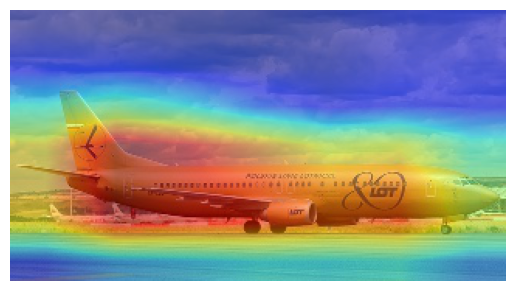

In [9]:
# 활성화 함수 시각화
import matplotlib.pyplot as plt


plt.imshow(image)
plt.imshow(cam, cmap="jet", alpha=0.5)
plt.axis("off")
plt.show()

### 3. Grad CAM
- Grad CAM은 CAM과 유사하지만 전역 평균풀링(GAP) 계층을 사용하지 않고, 마지막 합성곱 계층에서 역전파를 통해 클래스에 대한 중요도를 계산
- GAP를 학습하지 않는 모델은 모델 구조를 변경하여 재학습하여야 하기 때문에 CAM은 범용성이 떨어지고,
- 시각화를 위해 많은 리소스 필요
- Grad CAM은 가중치 대신 마지막 계층의 기울기 값을 사용하므로 모든 합성곱 신경망 구조에 적용 가능하며 기존 CAM보다 시각화 성능 우수

In [13]:
import torch


class GradCAM:
    def __init__(self, model, main, sub):
        self.model = model.eval()
        self.register_hook(main, sub)

    def register_hook(self, main, sub):
        for name, module in self.model.named_children():
            if name == main:
                for sub_name, sub_module in module[-1].named_children():
                    if sub_name == sub:
                        sub_module.register_forward_hook(self.forward_hook)
                        sub_module.register_full_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.feature_map = output  

    def backward_hook(self, module, grad_input, grad_output):
        self.gradient = grad_output[0]
        
    def __call__(self, x):
        output = self.model(x)

        index = output.argmax(axis=1)
        one_hot = torch.zeros_like(output)                
        for i in range(output.size(0)):
            one_hot[i][index[i]] = 1

        self.model.zero_grad()
        output.backward(gradient=one_hot, retain_graph=True)

        a_k = torch.mean(self.gradient, dim=(2, 3), keepdim=True)
        grad_cam = torch.sum(a_k * self.feature_map, dim=1)
        grad_cam = torch.relu(grad_cam)
        return grad_cam

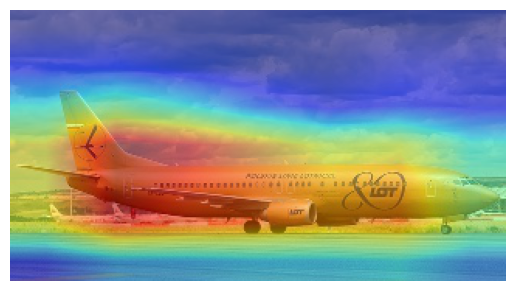

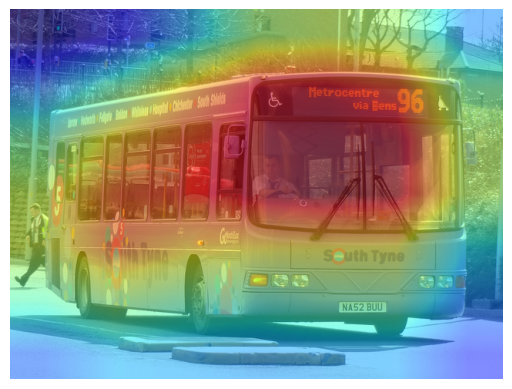

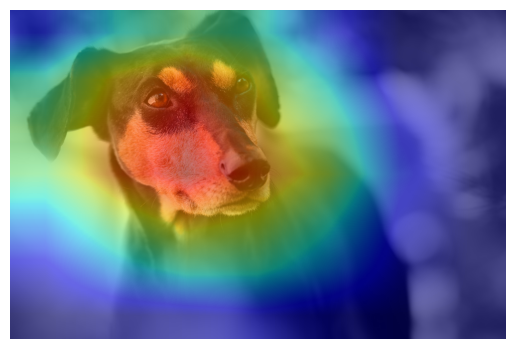

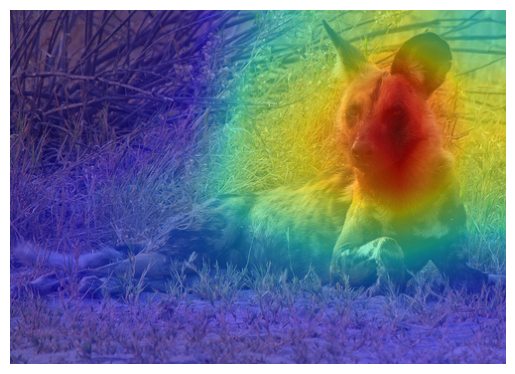

In [15]:
from PIL import Image
from torch.nn import functional as F
from torchvision import models
from torchvision import transforms
from matplotlib import pyplot as plt


transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        ),
    ]
)

files = [
    "../datasets/images/airplane.jpg", "../datasets/images/bus.jpg",
    "../datasets/images/dog.jpg", "../datasets/images/african_hunting_dog.jpg"
]
images, tensors = [], []
for file in files:
    image = Image.open(file)
    images.append(image)
    tensors.append(transform(image))
tensors = torch.stack(tensors)

model = GradCAM(
    model=models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1"),
    main="layer4",
    sub="conv2"
)
grad_cams = model(tensors)

for idx, image in enumerate(images):
    grad_cam = F.interpolate(
        input=grad_cams[idx].unsqueeze(0).unsqueeze(0),
        size=(image.size[1], image.size[0]),
        mode="bilinear",
    ).squeeze().detach().numpy()

    plt.imshow(image)
    plt.imshow(grad_cam, cmap="jet", alpha=0.5)
    plt.axis("off")
    plt.show()